In [16]:
# !gdown 1h7inwNSkLRH1RkpQU-hTnc6tWIWXmCmR

In [17]:
import pandas as pd
X_train = pd.read_csv(r"C:\Users\VIET HOANG - VTS\Desktop\BTTH1\UIT-VSFC\UIT-VSFC\train\sents.txt", sep='.', header=None, index_col=None)[0]
y_train = pd.read_csv(r"C:\Users\VIET HOANG - VTS\Desktop\BTTH1\UIT-VSFC\UIT-VSFC\train\topics.txt", header=None, index_col=None)
X_dev = pd.read_csv(r"C:\Users\VIET HOANG - VTS\Desktop\BTTH1\UIT-VSFC\UIT-VSFC\dev\sents.txt", sep='.',  header=None, index_col=None)[0]
y_dev = pd.read_csv(r"C:\Users\VIET HOANG - VTS\Desktop\BTTH1\UIT-VSFC\UIT-VSFC\dev\topics.txt", header=None, index_col=None)
X_test = pd.read_csv(r"C:\Users\VIET HOANG - VTS\Desktop\BTTH1\UIT-VSFC\UIT-VSFC\test\sents.txt",  sep='.', header=None, index_col=None)[0]
y_test = pd.read_csv(r"C:\Users\VIET HOANG - VTS\Desktop\BTTH1\UIT-VSFC\UIT-VSFC\test\topics.txt", header=None, index_col=None)

y_train = y_train.values.flatten()
y_dev = y_dev.values.flatten()
y_test = y_test.values.flatten()

Cách 1:

In [18]:
# make vocabulary
from pyvi import ViTokenizer

V=[]
for t in X_train:
  tokenized_sentence = ViTokenizer.tokenize(t)
  V = V + tokenized_sentence.split()
V = list(set(V))

# Building dictionary
word_to_index = {w : (i+2) for i, w in enumerate(V)}
word_to_index['UNK'] = 1
word_to_index['PAD'] = 0

# Building index2w
index_to_word = {i: w for w, i in word_to_index.items()}

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer

max_len = 100

def encoding(X):
  sentences = []
  for t in X:
    tokenized_sentence = ViTokenizer.tokenize(str(t))
    sentences.append(tokenized_sentence)
  X=[]
  for s in sentences:
    sent = []
    for w in s.split():
      try:
        w = w.lower()
        sent.append(word_to_index [w])
      except:
        sent.append(word_to_index ["UNK"])
    X.append(sent)
  # Padding du lieu theo do dai cau (maxlen)
  X = pad_sequences(maxlen = max_len, sequences = X,  padding = "post", value = word_to_index ["PAD"])

  return X

Cách 2:

In [20]:
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from pyvi import ViTokenizer
# from tensorflow.keras.preprocessing.text import Tokenizer

# word_tokenizer = Tokenizer(oov_token=-1)
# word_tokenizer.fit_on_texts(X_train)
# word_to_index = word_tokenizer.word_index
# word_to_index['PAD'] = 0
# word_to_index['UNK'] = -1
# index_to_word = {i: w for w, i in word_to_index.items()}

# def encoding(X):
#   sentences = []
#   for t in X:
#     tokenized_sentence = ViTokenizer.tokenize(t)
#     sentences.append(tokenized_sentence)
#   X = embedded_sentences = word_tokenizer.texts_to_sequences(sentences)
#   X = pad_sequences(maxlen = max_len, sequences = X,
#                     padding = "post",
#                     value = word_to_index["PAD"])

#   return X

In [21]:
X_train_encoded = encoding(X_train)
X_dev_encoded = encoding(X_dev)
X_test_encoded = encoding(X_test)

Huấn luyện mô hình

In [24]:
from keras.layers import Dense, Embedding, Flatten
from keras.models import Model
from keras.layers import Input
from keras.initializers import Constant

num_words = len(word_to_index)
input = Input(shape = (max_len, ))
emb = Embedding(input_dim=num_words, output_dim=300, input_length=max_len)(input)
flat = Flatten()(emb)
output = Dense(4, activation="sigmoid")(flat)
model = Model(input, output)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['binary_accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 100, 300)       │     1,119,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │       120,004 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,239,304 (4.73 MB)

 Trainable params: 1,239,304 (4.73 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from tensorflow.keras.utils import to_categorical

history = model.fit(X_train_encoded, to_categorical(y_train, num_classes=4), 
                    validation_data=(X_dev_encoded, to_categorical(y_dev, num_classes=4)), 
                    batch_size=128, epochs=10)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - binary_accuracy: 0.8488 - loss: 0.3591 - val_binary_accuracy: 0.9163 - val_loss: 0.2037
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - binary_accuracy: 0.9294 - loss: 0.1793 - val_binary_accuracy: 0.9368 - val_loss: 0.1610
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - binary_accuracy: 0.9506 - loss: 0.1353 - val_binary_accuracy: 0.9373 - val_loss: 0.1548
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - binary_accuracy: 0.9583 - loss: 0.1151 - val_binary_accuracy: 0.9390 - val_loss: 0.1541
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - binary_accuracy: 0.9673 - loss: 0.0947 - val_binary_accuracy: 0.9394 - val_loss: 0.1592
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - binary_accuracy: 0.9741 - loss: 0.0766 - val_binary_accuracy: 0.9367 - val_loss: 0.1635
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - binary_accuracy: 0.9791 - loss: 0.0671 - val_binary_accuracy: 0.9349 - val_loss: 0.1686
Epoch 8/10
90

In [26]:
import numpy as np
y_pred = model.predict(X_test_encoded)
y_pred_label = np.argmax(y_pred, axis=1)

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [27]:
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(y_pred_label, y_test)
f1 = f1_score(y_test, y_pred_label, average='micro')

print(f'Accuracy: {acc}')
print(f'F1 Score: {f1}')

Accuracy: 0.8711307643714467
F1 Score: 0.8711307643714467


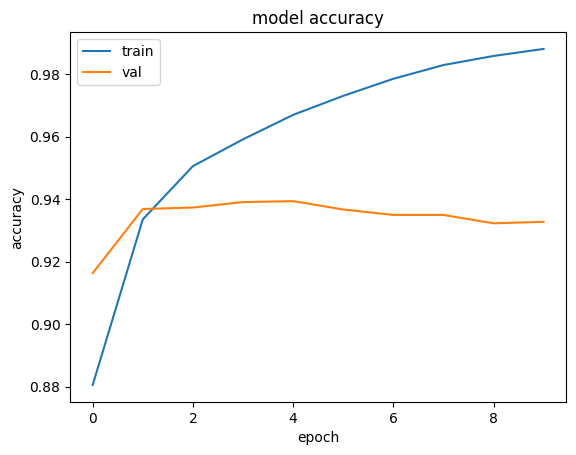

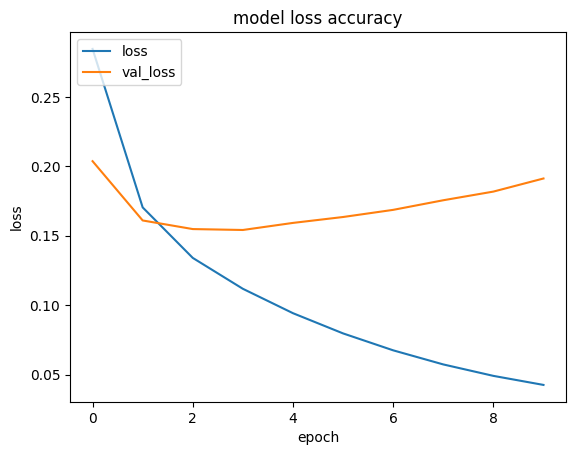

In [28]:
from matplotlib import pyplot as plt
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

**Sử dụng Pre-trained embedding**

In [29]:
word_dict = []
embeddings_index = {}
embedding_dim = 300
max_feature = len(embeddings_index) + 1
f = open('C2V.vec', encoding='utf-8')
for line in f:
    values = line.split(' ')
    word = values[0]
    word_dict.append(word)
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except Exception as e:
        pass
f.close()
print('Embedding data loaded')

Embedding data loaded


In [30]:
# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))
# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_to_index.items():
    if i > max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

In [31]:
from keras.layers import Dense, Embedding, Flatten, Input
from keras.models import Model
from keras.initializers import Constant
num_words = len(word_to_index)
input = Input(shape = (max_len, ))
emb = Embedding(input_dim=num_words,
                output_dim=embedding_dim,
embeddings_initializer= Constant(embedding_matrix),
                        input_length=max_len,
                        trainable=True)(input)

flat = Flatten()(emb)
output = Dense(4, activation="sigmoid")(flat)
model = Model(input, output)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['binary_accuracy'])
model.summary()

c:\Users\VIET HOANG - VTS\Desktop\VisionReader\cuda\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 100, 300)       │     1,119,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │       120,004 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,239,304 (4.73 MB)

 Trainable params: 1,239,304 (4.73 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
from tensorflow.keras.utils import to_categorical
history = model.fit(  X_train_encoded,
            to_categorical(y_train, num_classes=4),
            validation_data=(X_dev_encoded,
            to_categorical(y_dev, num_classes=4)),
            batch_size=128, epochs=10 )

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - binary_accuracy: 0.8203 - loss: 1.0828 - val_binary_accuracy: 0.9018 - val_loss: 0.3129
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - binary_accuracy: 0.9117 - loss: 0.2481 - val_binary_accuracy: 0.8943 - val_loss: 0.2350
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - binary_accuracy: 0.9327 - loss: 0.1715 - val_binary_accuracy: 0.9334 - val_loss: 0.1681
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - binary_accuracy: 0.9456 - loss: 0.1475 - val_binary_accuracy: 0.9139 - val_loss: 0.2287
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - binary_accuracy: 0.9501 - loss: 0.1312 - val_binary_accuracy: 0.9278 - val_loss: 0.1834
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - binary_accuracy: 0.9540 - loss: 0.1235 - val_binary_accuracy: 0.9329 - val_loss: 0.1684
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - binary_accuracy: 0.9597 - loss: 0.1041 - val_binary_accuracy: 0.9319 - val_loss: 0.1781
Epoch 8/10
90

In [33]:
import numpy as np
y_pred = model.predict(X_test_encoded)
y_pred_label = np.argmax(y_pred, axis=1)

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [34]:
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(y_pred_label, y_test)
f1 = f1_score(y_test, y_pred_label, average='micro')

print(f'Accuracy: {acc}')
print(f'F1 Score: {f1}')

Accuracy: 0.8534428300694883
F1 Score: 0.8534428300694883


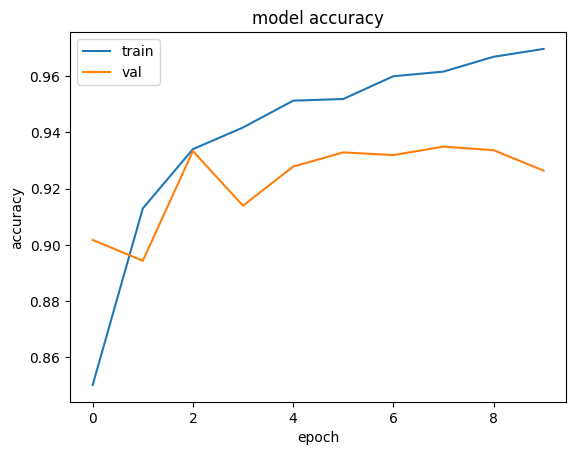

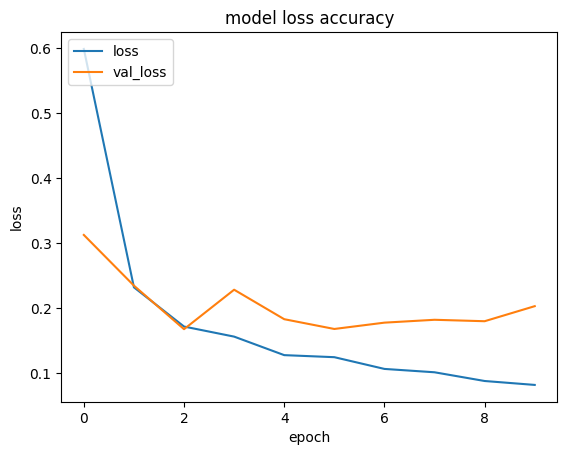

In [35]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()